In [10]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as f

In [1]:
col_names = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
df_news = pd.read_csv('/Users/ryomisawa/Downloads/NewsAggregatorDataset/newsCorpora.csv', sep = '\t', names=col_names)

df_news = df_news[(df_news['PUBLISHER'] == 'Reuters') | (df_news['PUBLISHER'] ==  'Huffington Post')|(df_news['PUBLISHER'] == 'Businessweek') | (df_news['PUBLISHER'] == 'Contactmusic.com') |(df_news['PUBLISHER'] == 'Daily Mail')].sample(frac=1, random_state=0).reset_index()

In [2]:
df_news['CATEGORY'].replace('b', 0, inplace=True)
df_news['CATEGORY'].replace('t', 1, inplace=True)
df_news['CATEGORY'].replace('e', 2, inplace=True)
df_news['CATEGORY'].replace('m', 3, inplace=True)

In [3]:
df_train, df_valid = train_test_split(df_news, test_size=0.2)
df_valid, df_test = train_test_split(df_valid, test_size=0.5)

In [4]:
df_train.reset_index(inplace=True)
df_valid.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_train.drop('index', axis=1, inplace=True)
df_valid.drop('index', axis=1, inplace=True)
df_test.drop('index', axis=1, inplace=True)
df_train.drop(436, axis=0, inplace=True)
df_train.reset_index(inplace=True)
df_train.drop('index', axis=1, inplace=True)

In [5]:
title_train = df_train['TITLE']
y_train = df_train['CATEGORY']
#y_train = torch.tensor(y_train).long()
title_valid = df_valid['TITLE']
y_valid = df_valid['CATEGORY']
#y_valid = torch.tensor(y_valid).long()
title_test = df_test['TITLE']
y_test = df_test['CATEGORY']
#y_test = torch.tensor(y_test).long()

In [7]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/ryomisawa/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

In [8]:
d = 300

x_train = []

for text in title_train:
    text = text.split()
    t = len(text)
    x = 0
    for word in text:
        if word not in model:
            x += np.zeros(d)
        else:
            x += model[word]
    x = x/t
    x_train.append(list(x))

In [11]:
x_valid = []

for text in title_valid:
    text = text.split()
    t = len(text)
    x = 0
    for word in text:
        if word not in model:
            x += np.zeros(d)
        else:
            x += model[word]
    x = x/t
    x_valid.append(list(x))
x_valid = torch.tensor(x_valid).float()

In [12]:
x_test = []

for text in title_test:
    text = text.split()
    t = len(text)
    x = 0
    for word in text:
        if word not in model:
            x += np.zeros(d)
        else:
            x += model[word]
    x = x/t
    x_test.append(list(x))
x_test = torch.tensor(x_test).float()

In [13]:
L = 4
W = torch.randn(d, L, requires_grad=True)
x_1 = torch.tensor(x_train[0])
x_1_4 = torch.tensor([x_train[0], x_train[1], x_train[2], x_train[3]])
y_1 = f.softmax(torch.matmul(x_1, W))
Y = f.softmax(torch.matmul(x_1_4, W))

In [14]:
l_1 = -torch.log(y_1[y_train[0]])
l_1_4 = 0
for i in range(4):
    l_1_4 += -torch.log(Y[i][y_train[i]])
l_1_4 = l_1_4/4

In [15]:
l_1.backward()
W.grad

tensor([[ 0.0174, -0.0125, -0.0021, -0.0028],
        [-0.0683,  0.0489,  0.0083,  0.0112],
        [ 0.0335, -0.0239, -0.0041, -0.0055],
        ...,
        [ 0.0129, -0.0092, -0.0016, -0.0021],
        [-0.0594,  0.0425,  0.0072,  0.0097],
        [ 0.0117, -0.0084, -0.0014, -0.0019]])

In [16]:
l_1_4.backward()
W.grad

tensor([[ 0.0015, -0.0046,  0.0040, -0.0009],
        [-0.1004,  0.0592,  0.0277,  0.0135],
        [ 0.0610, -0.0528,  0.0029, -0.0111],
        ...,
        [ 0.0050, -0.0108,  0.0075, -0.0018],
        [-0.1163,  0.0810,  0.0178,  0.0175],
        [ 0.0346, -0.0384,  0.0099, -0.0061]])

In [89]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).long()

In [17]:
x_train = torch.tensor(x_train).float()
epoch = 101
W = torch.randn(d, L, requires_grad=True)
optimizer = optim.SGD([W], lr=0.1)
for i in range(epoch):
     y = f.softmax(torch.matmul(x_train, W))
     l = 0
     for j in range(len(x_train)):
         l += -torch.log(y[j][y_train[j]])
     l = l/len(x_train)

     optimizer.zero_grad()
     l.backward()

     optimizer.step()
     
     if i % 10 == 0:
         print(l.item())

1.6179335117340088


KeyboardInterrupt: 

In [208]:
y_pred_train = f.softmax(torch.matmul(x_train, W))
y_pred_test = f.softmax(torch.matmul(x_test, W))

In [209]:
print('Train Accuracy: {:.3f}, Test Accuracy: {:.3f}'.format(accuracy_score(y_train, y_pred_train.argmax(axis=1)), accuracy_score(y_test, y_pred_test.argmax(axis=1))))


Train Accuracy: 0.390, Test Accuracy: 0.373


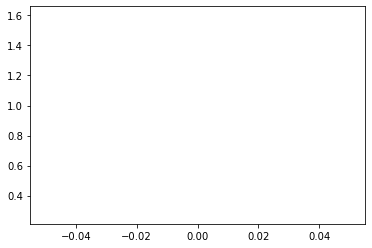

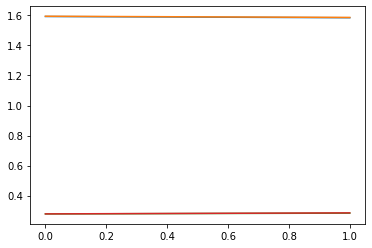

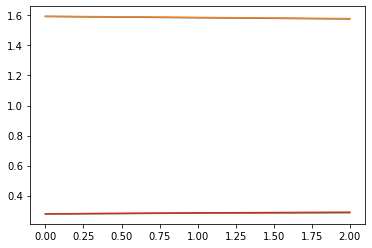

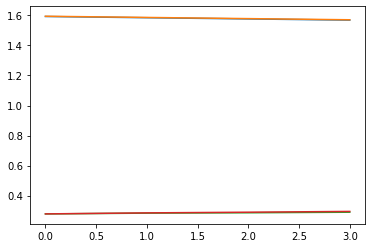

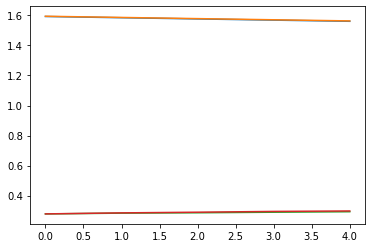

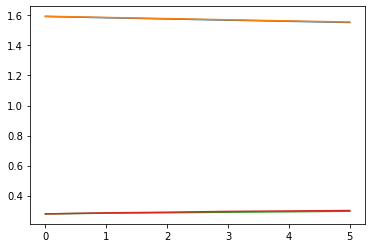

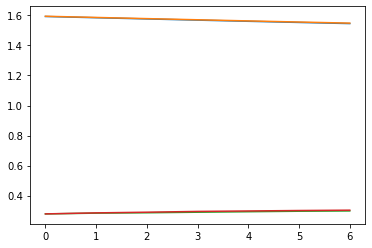

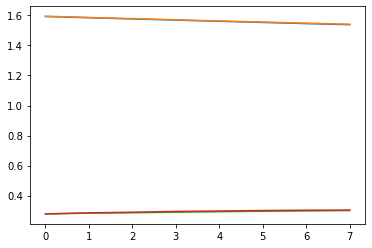

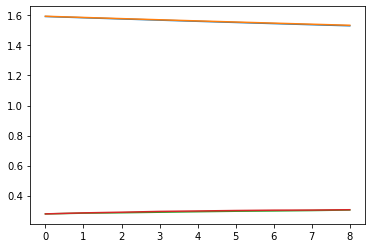

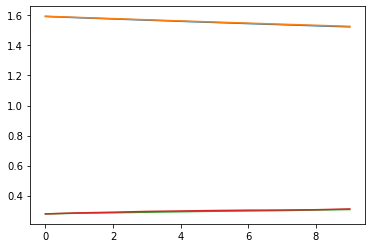

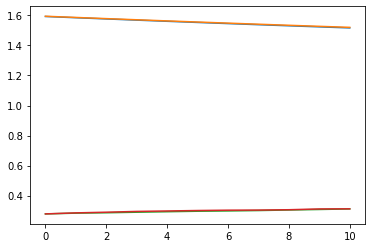

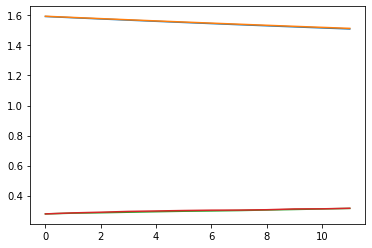

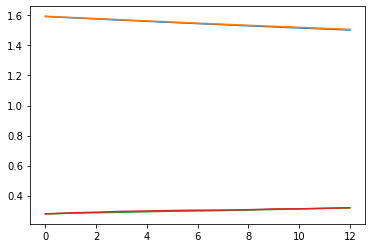

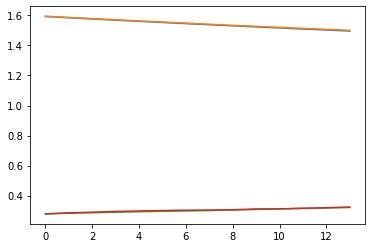

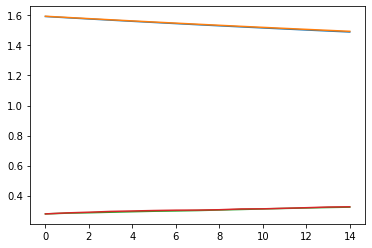

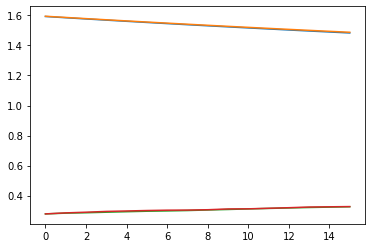

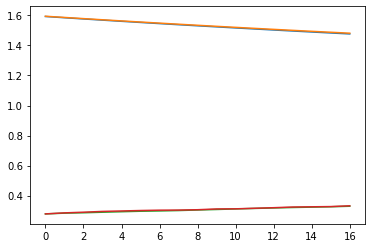

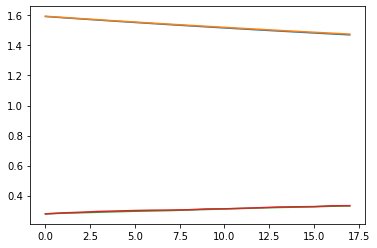

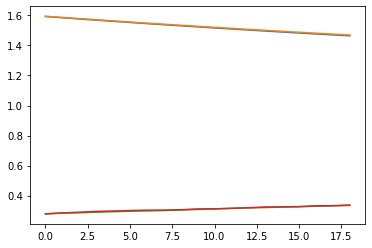

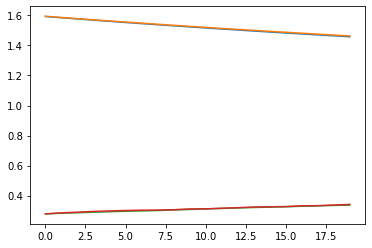

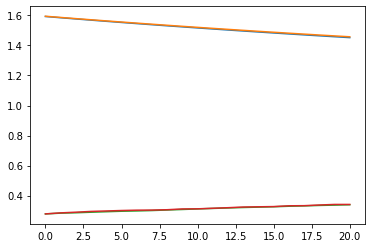

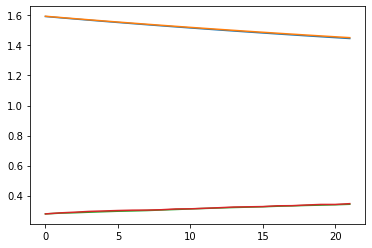

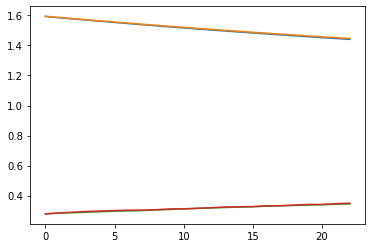

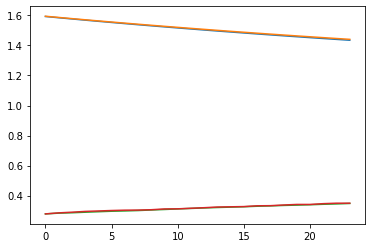

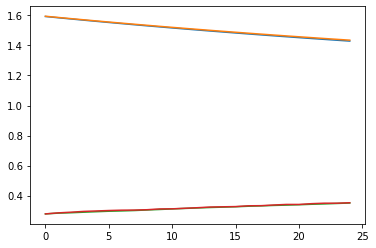

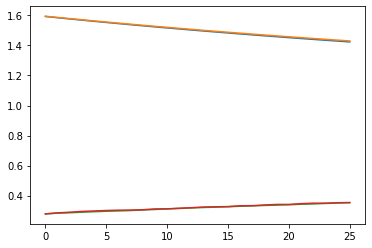

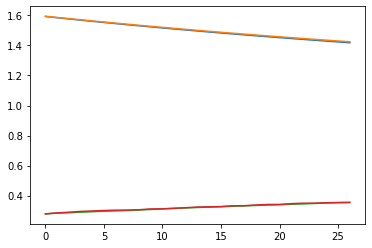

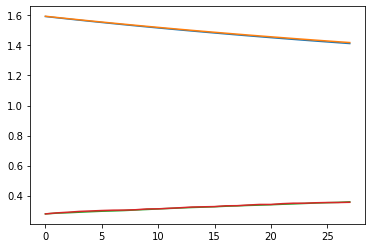

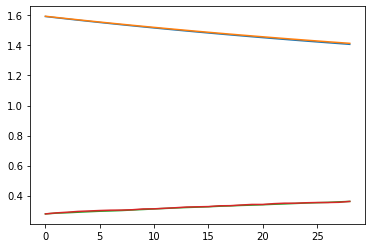

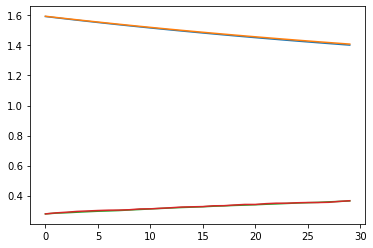

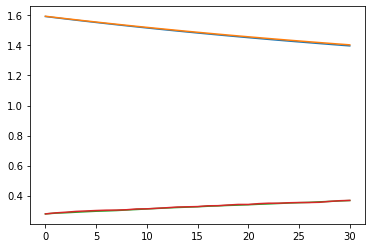

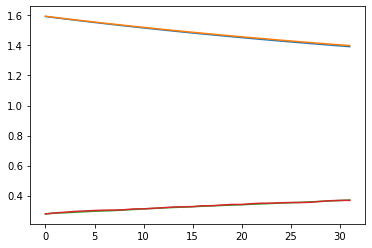

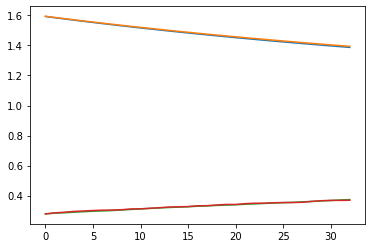

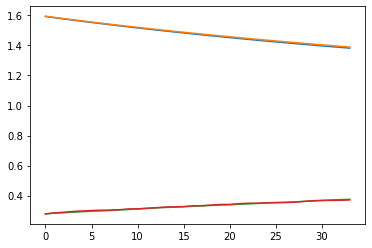

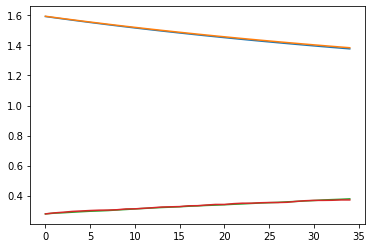

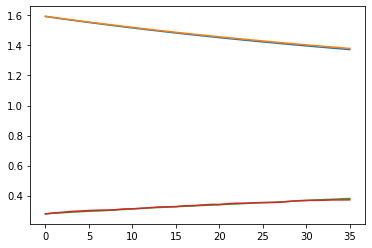

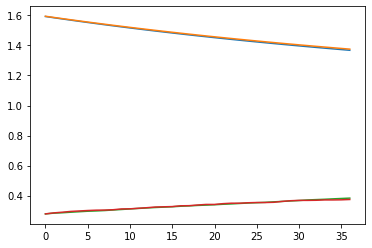

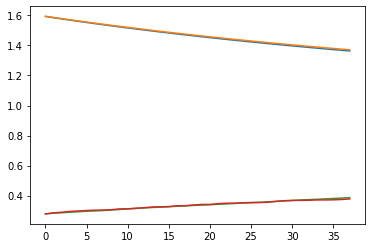

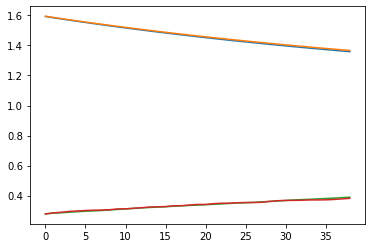

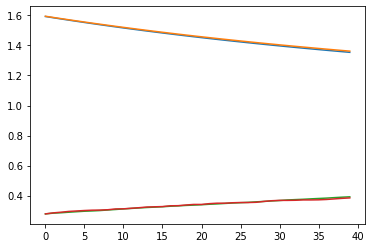

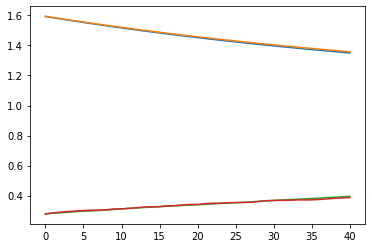

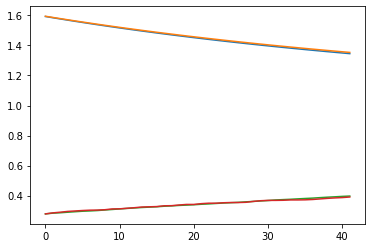

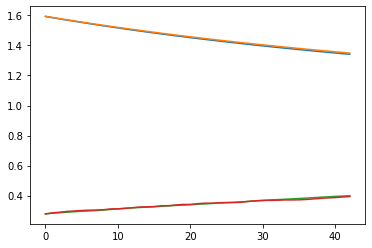

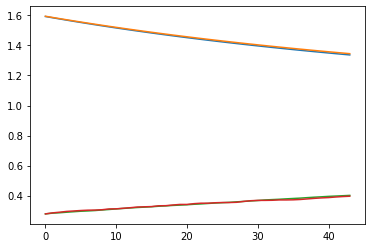

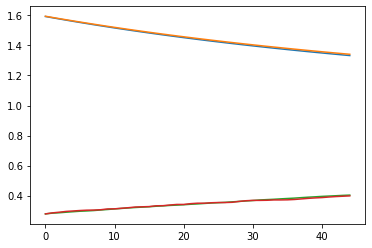

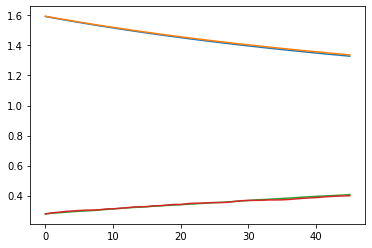

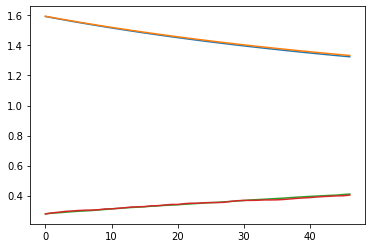

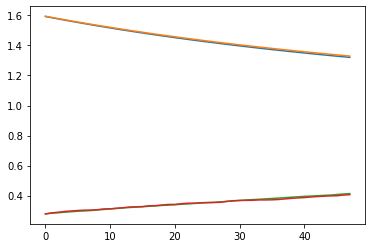

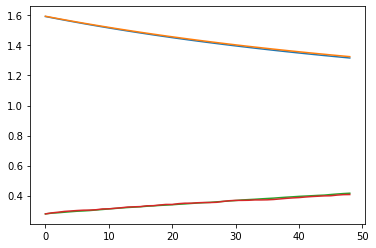

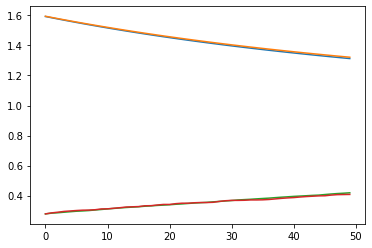

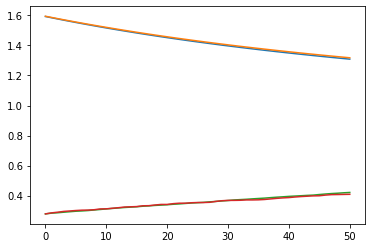

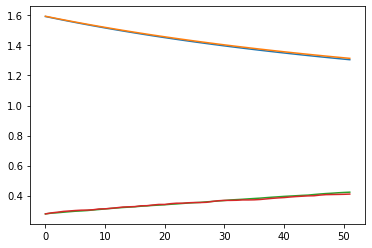

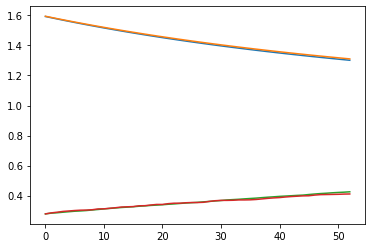

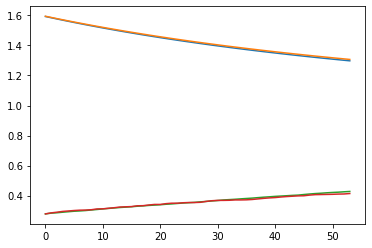

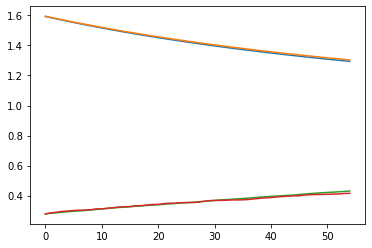

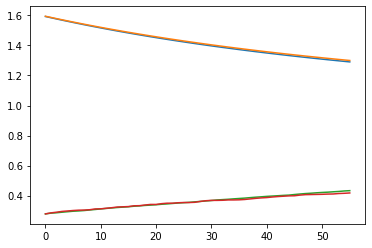

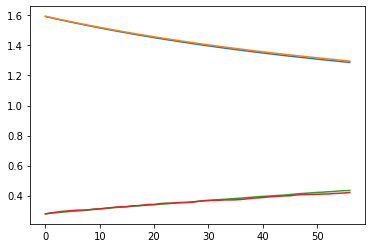

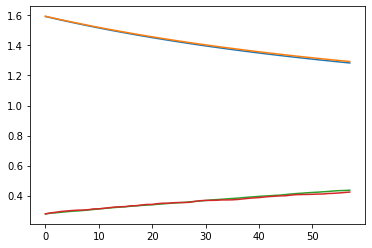

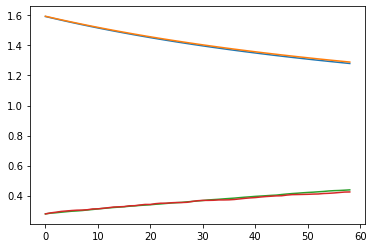

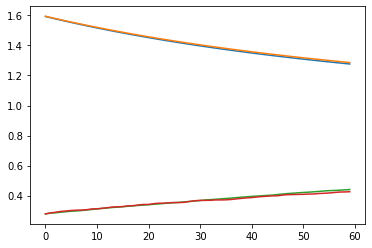

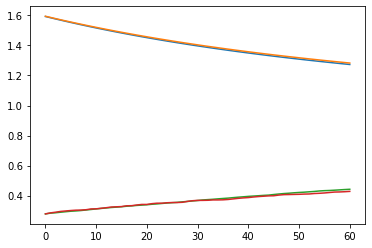

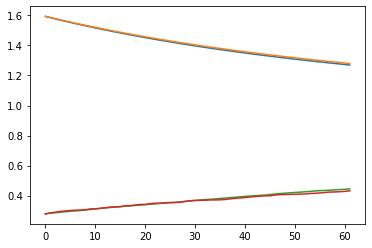

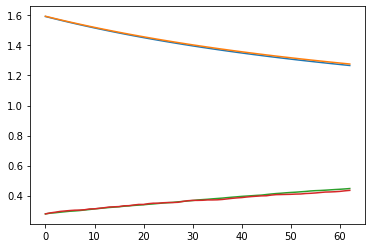

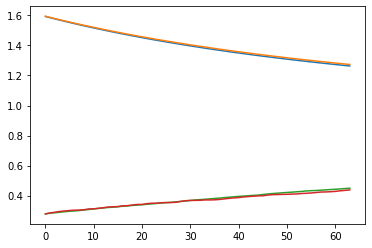

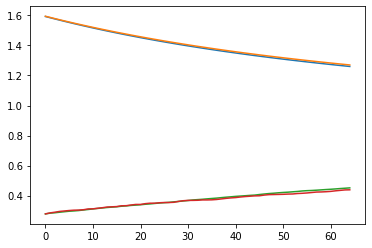

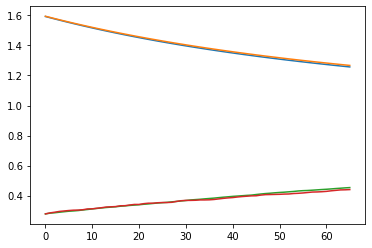

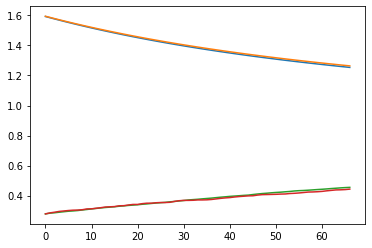

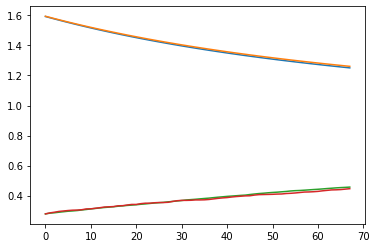

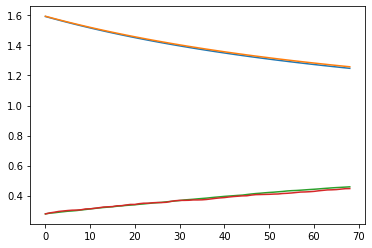

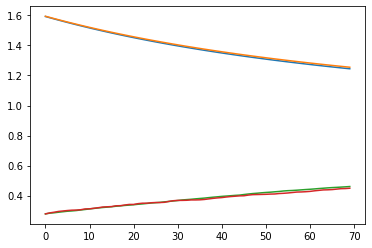

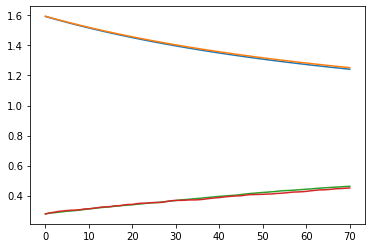

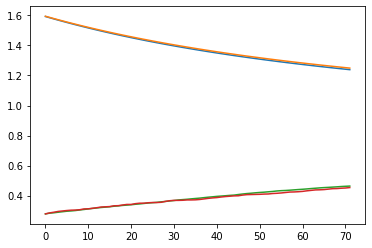

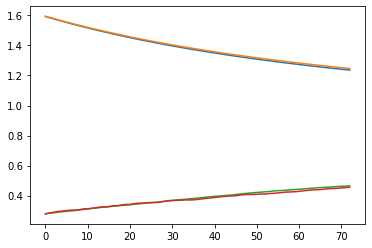

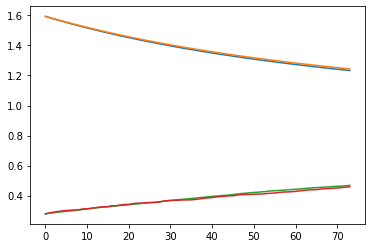

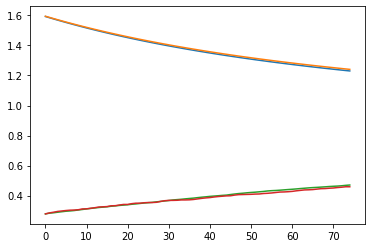

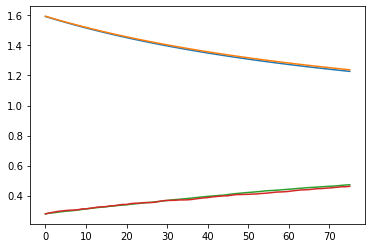

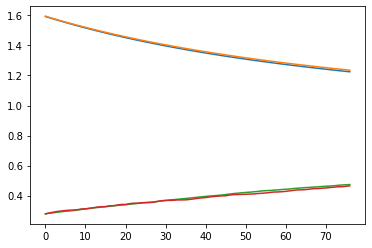

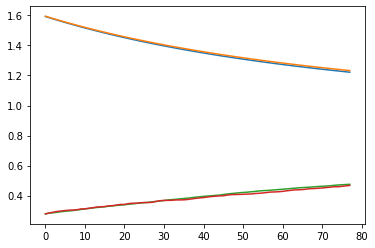

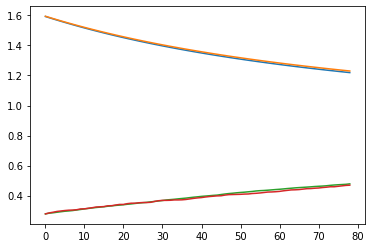

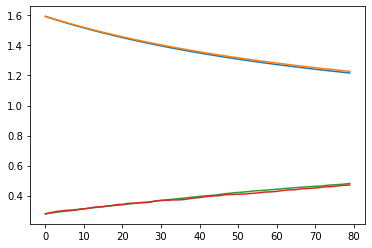

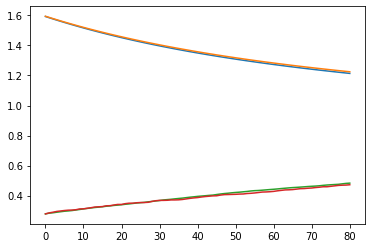

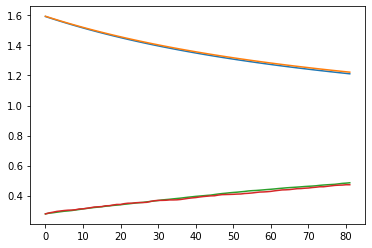

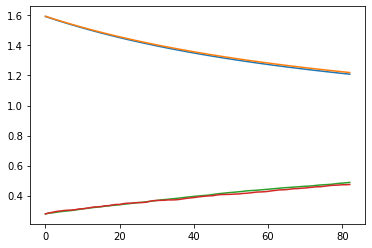

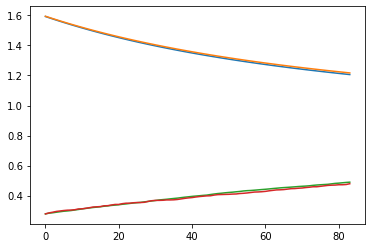

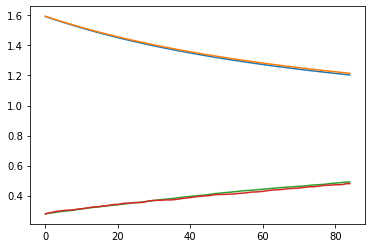

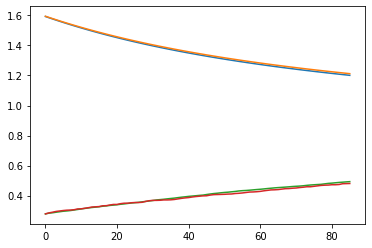

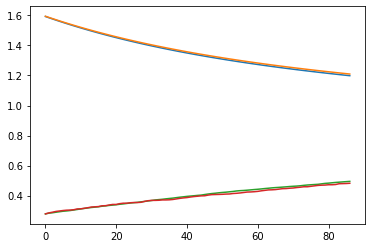

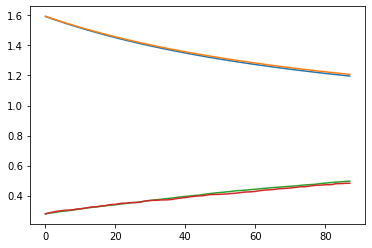

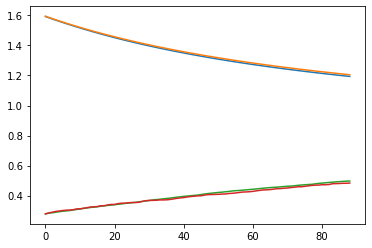

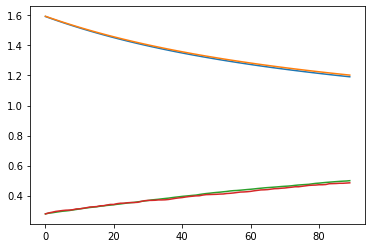

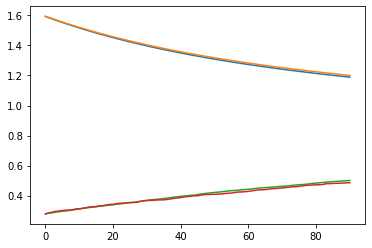

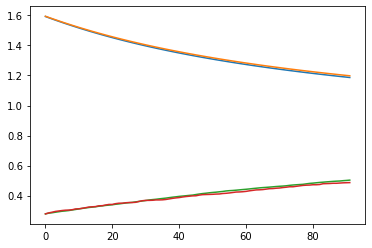

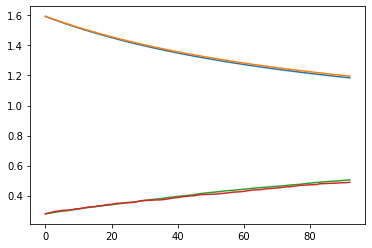

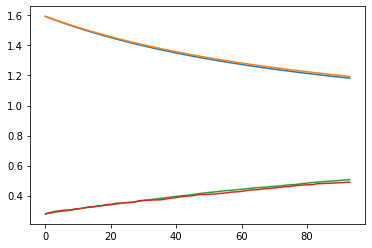

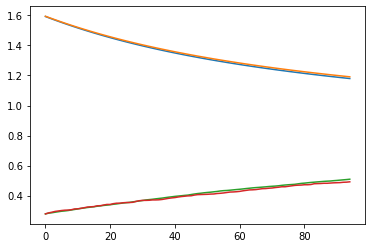

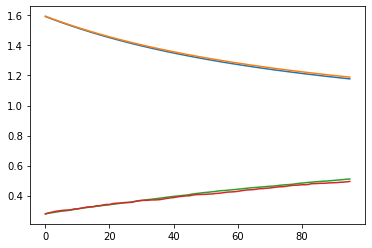

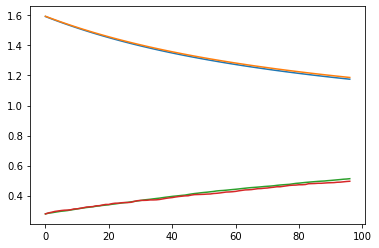

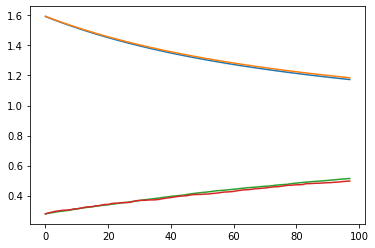

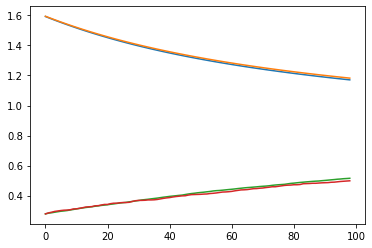

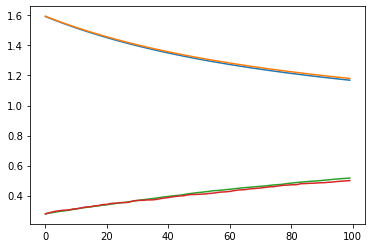

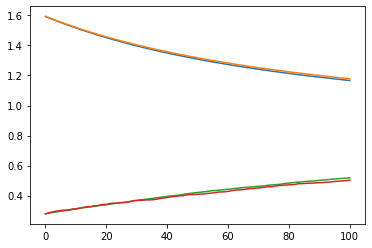

In [255]:
W = torch.randn(d, L, requires_grad=True)
loss_train = []
loss_valid = []
acc_train = []
acc_valid = []
optimizer = optim.SGD([W], lr=0.1)
for i in range(epoch):
     pred_train = f.softmax(torch.matmul(x_train, W))
     l_train = 0
     for j in range(len(x_train)):
         l_train += -torch.log(pred_train[j][y_train[j]])
     l_train = l_train/len(x_train)

     optimizer.zero_grad()
     l_train.backward()

     optimizer.step()

     pred_valid = f.softmax(torch.matmul(x_valid, W))
     l_valid = 0
     for j in range(len(x_valid)):
         l_valid += -torch.log(pred_valid[j][y_valid[j]])
     l_valid = l_valid/len(x_valid)

     y_pred_train = f.softmax(torch.matmul(x_train, W))
     y_pred_valid = f.softmax(torch.matmul(x_valid, W))
     
     loss_train.append(l_train.item())
     loss_valid.append(l_valid.item())
     acc_train.append(accuracy_score(y_train, y_pred_train.argmax(axis=1)))
     acc_valid.append(accuracy_score(y_valid, y_pred_valid.argmax(axis=1)))

     x = [i for i in range(len(loss_train))]
     plt.plot(x, loss_train)
     plt.plot(x, loss_valid)
     plt.plot(x, acc_train)
     plt.plot(x, acc_valid)
     plt.show()

    

In [37]:
W = torch.randn(d, L, requires_grad=True)

loss_train = []
loss_valid = []
acc_train = []
acc_valid = []
optimizer = optim.SGD([W], lr=0.1)
for i in range(10):
     pred_train = f.softmax(torch.matmul(x_train, W))
     l_train = 0
     for j in range(len(x_train)):
         l_train += -torch.log(pred_train[j][y_train[j]])
     l_train = l_train/len(x_train)

     optimizer.zero_grad()
     l_train.backward()

     optimizer.step()

     pred_valid = f.softmax(torch.matmul(x_valid, W))
     l_valid = 0
     for j in range(len(x_valid)):
         l_valid += -torch.log(pred_valid[j][y_valid[j]])
     l_valid = l_valid/len(x_valid)

     y_pred_train = f.softmax(torch.matmul(x_train, W))
     y_pred_valid = f.softmax(torch.matmul(x_valid, W))
     
     loss_train.append(l_train.item())
     loss_valid.append(l_valid.item())
     acc_train.append(accuracy_score(y_train, y_pred_train.argmax(axis=1)))
     acc_valid.append(accuracy_score(y_valid, y_pred_valid.argmax(axis=1)))

     #x = [i for i in range(len(loss_train))]
     #plt.plot(x, loss_train)
     #plt.plot(x, loss_valid)
     #plt.plot(x, acc_train)
     #plt.plot(x, acc_valid)
     #plt.show()

     torch.save(
         {
             'epoch':i,
             'weight':W,
             'optimizer_state_dict':optimizer.state_dict()
         },
         'model{}.pth'.format(i)
     )

In [41]:
num_data = y_train.shape[0]

In [84]:
import time

W = torch.randn(d, L, requires_grad=True)
loss_train = []
loss_valid = []
acc_train = []
acc_valid = []
optimizer = optim.SGD([W], lr=0.1)

num_data_train = len(x_train)
num_data_valid = len(x_valid)
batch_size = 8

for i in range(10):
     t1 = time.time()
     sff_idx_t = np.random.permutation(num_data_train)
     sff_idx_v = np.random.permutation(num_data_valid)

     for idx in range(0, num_data_train, batch_size):
         
         x_batch = x_train[sff_idx_t[idx: idx + batch_size if idx + batch_size < num_data_train else num_data_train]]
         y_batch = y_train[sff_idx_t[idx: idx + batch_size if idx + batch_size < num_data_train else num_data_train]]
         pred_train = f.softmax(torch.matmul(x_batch, W))
         y_batch.reset_index(inplace=True, drop=True)
         
         l_train = 0
         for index in y_batch.index:
             l_train += -torch.log(pred_train[index][y_batch[index]])
         l_train = l_train/len(x_batch)

         optimizer.zero_grad()
         l_train.backward()

         optimizer.step()
     
     for idx in range(0, num_data_valid, batch_size):
         x_batch = x_valid[sff_idx_v[idx: idx + batch_size if idx + batch_size < num_data_valid else num_data_valid]]
         y_batch = y_valid[sff_idx_v[idx: idx + batch_size if idx + batch_size < num_data_valid else num_data_valid]]
         pred_valid = f.softmax(torch.matmul(x_batch, W))
         y_batch.reset_index(inplace=True, drop=True)

         l_valid = 0
         for index in y_batch.index:
             l_valid += -torch.log(pred_valid[index][y_batch[index]])
         l_valid = l_valid/len(x_batch)
         y_pred_valid = f.softmax(torch.matmul(x_batch, W))
     t2 = time.time()
     elapsed_time = t2 - t1
     print(f'経過時間:{elapsed_time}', l_train.item(), l_valid.item())

     if i == 9:
         times.append(elapsed_time)
     #loss_train.append(l_train.item())
     #loss_valid.append(l_valid.item())
     #acc_train.append(accuracy_score(y_train, y_pred_train.argmax(axis=1)))
     #acc_valid.append(accuracy_score(y_valid, y_pred_valid.argmax(axis=1)))

     #x = [i for i in range(len(loss_train))]
     #plt.plot(x, loss_train)
     #plt.plot(x, loss_valid)
     #plt.plot(x, acc_train)
     #plt.plot(x, acc_valid)
     #plt.show()

     torch.save(
         {
             'epoch':i,
             'weight':W,
             'optimizer_state_dict':optimizer.state_dict()
         },
         'model{}.pth'.format(i)
     )

経過時間:2.154776096343994 0.6873860955238342 1.0991803407669067
経過時間:1.9213950634002686 0.4816839098930359 0.7689582705497742
経過時間:1.9515178203582764 0.8552832007408142 0.784386157989502
経過時間:2.156125068664551 0.8387746810913086 1.1352676153182983
経過時間:2.2080609798431396 0.2090076059103012 0.3258337378501892
経過時間:2.347372055053711 0.08405240625143051 0.8807896971702576
経過時間:2.247919797897339 0.3658575117588043 1.0024676322937012
経過時間:2.4529738426208496 0.09325527399778366 0.1261565089225769
経過時間:2.105158805847168 0.2898283302783966 0.09943003207445145
経過時間:2.059769868850708 0.188587948679924 0.5492203235626221


In [47]:
num_data_train

10671

In [58]:
y_batch.reset_index(inplace=True, drop=True)

In [59]:
y_batch

0    2
1    2
Name: CATEGORY, dtype: int64

In [79]:
times = []

In [96]:
import time

W = torch.randn(d, L, requires_grad=True)
loss_train = []
loss_valid = []
acc_train = []
acc_valid = []
optimizer = optim.SGD([W], lr=0.1)

num_data_train = len(x_train)
num_data_valid = len(x_valid)
batch_size = 8

for i in range(10):
     t1 = time.time()
     sff_idx_t = np.random.permutation(num_data_train)
     sff_idx_v = np.random.permutation(num_data_valid)

     for idx in range(0, num_data_train, batch_size):
         
         x_batch = x_train[sff_idx_t[idx: idx + batch_size if idx + batch_size < num_data_train else num_data_train]]
         y_batch = y_train[sff_idx_t[idx: idx + batch_size if idx + batch_size < num_data_train else num_data_train]]

         x_batch = x_batch.to(device)
         y_batch = y_batch.to(device)

         pred_train = f.softmax(torch.matmul(x_batch, W))
         
         l_train = 0
         for i in range(len(y_batch)):
             l_train += -torch.log(pred_train[i][y_batch[i]])
         l_train = l_train/len(x_batch)

         optimizer.zero_grad()
         l_train.backward()

         optimizer.step()
     
     for idx in range(0, num_data_valid, batch_size):
         x_batch = x_valid[sff_idx_v[idx: idx + batch_size if idx + batch_size < num_data_valid else num_data_valid]]
         y_batch = y_valid[sff_idx_v[idx: idx + batch_size if idx + batch_size < num_data_valid else num_data_valid]]

         x_batch = x_batch.to(device)
         y_batch = y_batch.to(device)
         
         pred_valid = f.softmax(torch.matmul(x_batch, W))
         

         l_valid = 0
         for i in range(len(y_batch)):
             l_valid += -torch.log(pred_valid[i][y_batch[i]])
         l_valid = l_valid/len(x_batch)
         y_pred_valid = f.softmax(torch.matmul(x_batch, W))
     t2 = time.time()
     elapsed_time = t2 - t1
     print(f'経過時間:{elapsed_time}', l_train.item(), l_valid.item())

     if i == 9:
         times.append(elapsed_time)
     #loss_train.append(l_train.item())
     #loss_valid.append(l_valid.item())
     #acc_train.append(accuracy_score(y_train, y_pred_train.argmax(axis=1)))
     #acc_valid.append(accuracy_score(y_valid, y_pred_valid.argmax(axis=1)))

     #x = [i for i in range(len(loss_train))]
     #plt.plot(x, loss_train)
     #plt.plot(x, loss_valid)
     #plt.plot(x, acc_train)
     #plt.plot(x, acc_valid)
     #plt.show()

     torch.save(
         {
             'epoch':i,
             'weight':W,
             'optimizer_state_dict':optimizer.state_dict()
         },
         'model{}.pth'.format(i)
     )

経過時間:1.8112101554870605 0.3523988425731659 1.1823145151138306
経過時間:1.035250186920166 0.5984949469566345 0.6616277098655701
経過時間:0.937842845916748 0.36876681447029114 0.2322908490896225
経過時間:0.9303109645843506 0.7908144593238831 0.16316412389278412
経過時間:0.8840780258178711 0.25373929738998413 0.06157281622290611
経過時間:0.8940060138702393 0.30693742632865906 0.21997465193271637
経過時間:0.888746976852417 0.3788197934627533 0.14811356365680695
経過時間:0.8952090740203857 0.5243347883224487 0.0470120795071125
経過時間:0.893867015838623 0.7787889838218689 0.5613839030265808
経過時間:0.9150938987731934 0.8279498815536499 0.3283385634422302


In [83]:
times

[5.549889087677002, 2.9659740924835205]

In [85]:
device = torch.device('cude' if torch.cuda.is_available() else 'cpu')

In [91]:
y_batch

tensor([1, 2, 3, 0, 0, 2, 3, 0])

In [93]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).long()
x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).long()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).long()